In [1]:
from ngsolve import *
from netgen.occ import unit_square
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

## Problem formulation

Cost function

\begin{equation}
    \min\limits_{u} J(y,u) := \int\limits_{\Omega} \left(y-y_{ref}\right)^2 \;\mathrm{d}x + \lambda \int\limits_{\partial \Omega} u^2 \;\mathrm{d}s,
    \label{eq:minimisation}
    \tag{MinProblem}
\end{equation}

subject to $y \in H^1 (\Omega)$ solves

\begin{align}
    -\Delta y &= 0 &\text{in } \Omega \label{pdedomain}\tag{PDE-Domain}\\
    \partial_\nu y &= -\alpha (y-u) \quad &\text{on }\partial \Omega \label{pdeboundary}\tag{PDE-Boundary}
\end{align}

The adjoint state $p \in H^1(\Omega)$

\begin{align}
    -\Delta p &= 2(\bar{y} - y_{ref}) \quad &\text{in } \Omega \label{adjointdomain}\tag{Adjoint-Domain}\\
    \partial_\nu p &= -\alpha p \quad &\text{on }\partial \Omega \label{adjointboundary}\tag{Adjoint-Boundary}
\end{align}

#### Weak forms

\begin{align}
    \text{PDE weak form:} \quad &A(y,\varphi) &= f(\varphi) \quad &\forall \varphi \in H^1(\Omega)\\
    \text{Adjoint weak form:} \quad &A_{adj}(p,\psi) &= f_{adj}(\psi) \quad &\forall \psi \in H^1(\Omega)
\end{align}

with the bilinear and linear forms

\begin{align}
    A(y, \varphi) &= \int\limits_\Omega \nabla y \cdot \nabla \varphi \;\mathrm{d} x + \int_{\partial \Omega} \!\alpha\, y\, \varphi \;\mathrm{d}s\\
    f(\varphi) &= \int_{\partial \Omega} \!\alpha\, u\, \varphi \;\mathrm{d}s\\
    A_{adj} (p,\psi) &= \int\limits_\Omega \nabla p \cdot \nabla \psi \;\mathrm{d}x + \int\limits_{\partial \Omega} \alpha p \psi \;\mathrm{d}s\\
    f_{adj} (\psi) &= \int\limits_\Omega -2(y_u - y_{ref}) \psi \;\mathrm{d}x
\end{align}

#### Descent direction

\begin{equation}
    v_n := -(2\lambda u_n - \alpha p_n)
\end{equation}

The time step size $t_n$ is determined by

\begin{equation}
    \min\limits_{t>0} J \left(\Pi_{[u_a, u_b]} (u_n + t v_n)\right) = J \left(\Pi_{[u_a, u_b]} (u_n + t_n v_n)\right)
\end{equation}

The control in the next step is

\begin{equation}
    u_{n+1} = \Pi_{[u_a, u_b]} (u_n + t_n v_n)
\end{equation}



In [2]:
eps = 1e-15
maxh = 0.1
mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))

Define FE-space, set control bounds and create `GridFunction`s.

`ua.Set(...)` and `ub.Set(...)` sets the bounds for the control.

In [3]:
fes = H1(mesh, order=1)
fes_bnd = SurfaceL2(mesh, order=0)

yt,phi = fes.TnT()
p,psi = fes.TnT()     # Adjoint state variable

# Bounds for control
ua = GridFunction(fes_bnd)
ub = GridFunction(fes_bnd)

u = GridFunction(fes_bnd)    # Control
u.Set(0.0, definedon=mesh.Boundaries(".*"))
yref = GridFunction(fes)  # Reference y
yn = GridFunction(fes)    # Solution to PDE
pn = GridFunction(fes)    # Solution to adjoint
v_desc = GridFunction(fes_bnd) # Descent direction
u_projected = GridFunction(fes_bnd)
alpha = GridFunction(fes_bnd)

# Create NumPy Arrays of GridFunctions
ua_np = ua.vec.FV().NumPy()
ub_np = ub.vec.FV().NumPy()

The following cell is only used for the `plot_control`-function: it plots the control and shows their values.

In [4]:
coord_bnd = GridFunction(fes_bnd)
coord_bnd.Set(x, definedon=mesh.Boundaries(".*"))
bnd_x = np.copy(coord_bnd.vec.FV().NumPy())
coord_bnd.Set(y, definedon=mesh.Boundaries(".*"))
bnd_y = np.copy(coord_bnd.vec.FV().NumPy())

indices_left = np.where(bnd_x < eps)
indices_right = np.where(np.abs(1 - bnd_x) < eps)
indices_top = np.where(np.abs(1-bnd_y) < eps)
indices_bottom = np.where(bnd_y < eps)

normals_x = np.zeros_like(ua_np)
normals_y = np.zeros_like(normals_x)
normals_x[indices_left] = -1
normals_x[indices_right] = 1
normals_y[indices_bottom] = -1
normals_y[indices_top] = 1

uuu = GridFunction(fes)
uuu.Set(x)
gridx = np.copy(uuu.vec.FV().NumPy())
uuu.Set(y)
gridy = np.copy(uuu.vec.FV().NumPy())

triang = tri.Triangulation(gridx, gridy)

def plot_control(yu, u, plot_inside=True):
    u_np = u.vec.FV().NumPy()
    u_nx = np.multiply(u_np, normals_x)
    u_ny = np.multiply(u_np, normals_y)
    plt.plot([0,1,1,0,0], [0,0,1,1,0])
    cs = plt.quiver(bnd_x, bnd_y, u_nx, u_ny, u_np)
    if plot_inside:
        plt.tricontourf(triang, yu.vec.FV().NumPy(), cmap="bone", alpha=0.5)
        plt.colorbar(cs, label="u")
    plt.axis("equal")
    plt.ylim([-0.2, 1.2])
    plt.title("Control values")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()

### Setting $\lambda,\, \alpha,\, y_{ref}$

`case` selects the example to be run

In [5]:
case = 2

if case == 1:
    lam = 0.2
    alpha.Set(1.0, definedon=mesh.Boundaries(".*"))
    yref.Set(1-16*(x-0.5)**2*(y-0.5)**2)
    ua.Set(0.0, definedon=mesh.Boundaries(".*"))
    ub.Set(2.0, definedon=mesh.Boundaries(".*"))
elif case == 2:
    lam = 10.2
    alpha.Set(1.0, definedon=mesh.Boundaries("top"))
    yref.Set((x+y)/2)
    ua.Set(0.0, definedon=mesh.Boundaries(".*"))
    ub.Set(2.0, definedon=mesh.Boundaries(".*"))
elif case == 3:
    lam = 0.002
    alpha.Set(1.0, definedon=mesh.Boundaries(".*"))
    yref.Set(100*cos(2*pi*x)*cos(2*pi*y))
    ua.Set(-0.1, definedon=mesh.Boundaries(".*"))
    ub.Set(0.1, definedon=mesh.Boundaries(".*"))
else:
    raise NotImplementedError("Choose case 1,2 or 3.")

In [6]:
def J(yn, u):
    int1 = Integrate((yn-yref)**2, mesh)
    int2 = lam * Integrate(u**2, mesh, BND)
    return int1 + int2

In [7]:
# State PDE
A  = BilinearForm(fes)
A += grad(yt)*grad(phi) * dx
A += alpha*yt*phi * ds
A.Assemble()
A_inv = A.mat.Inverse(freedofs=fes.FreeDofs())

f  = LinearForm(fes)
f += alpha*u * phi * ds

# Adjoint equation
A_adj  = BilinearForm(fes)
A_adj += grad(p)*grad(psi) * dx
A_adj += alpha*p*psi * ds
A_adj.Assemble()
A_adj_inv = A_adj.mat.Inverse(freedofs=fes.FreeDofs())

f_adj  = LinearForm(fes)
f_adj += -2*(yn-yref) * psi * dx

In [8]:
def control_to_state(u,y_u):
    f_temp = LinearForm(fes)
    f_temp += alpha*u * phi * ds
    f_temp.Assemble()
    y_u.vec.data = A_inv.matvec(f_temp.vec)

In [9]:
def line_search(niters=10, t1=10, plot_descent=False):
    t0 = 0
    ynew = GridFunction(fes)
    unew = GridFunction(fes_bnd)
    
    def compute_cost(ti):
        unew.Set(u+ti*v_desc, definedon=mesh.Boundaries(".*"))
        # Project to U_admissible
        unew.vec.FV().NumPy()[:] = np.clip(unew.vec.FV().NumPy(), ua_np, ub_np)
        control_to_state(unew, ynew)
        return J(ynew, unew)
    
    J0 = compute_cost(t0)
    J1 = compute_cost(t1)
    t_list = [t0,t1]
    J_list = [J0,J1]
    J_optimal = min(J0,J1)
    t_optimal = t0 if J0<J1 else t1
    
    for i in range(niters):
        trange = t1-t0
        tmid = t0 + trange/2
        Jmid = compute_cost(tmid)
        t_list.append(tmid)
        J_list.append(Jmid)
        if Jmid < J_optimal:
            t_optimal = tmid
            J_optimal = Jmid
        if J0 < J1:
            t1 = tmid
            J1 = Jmid
        else:
            t0 = tmid
            J0 = Jmid
    
    sorted_indices = np.argsort(t_list)
    t_sorted = np.array(t_list)[sorted_indices]
    J_sorted = np.array(J_list)[sorted_indices]
    J_opt = np.min(J_sorted[1:])
    t_opt = t_sorted[np.argmin(J_sorted[1:])+1]
    
    if plot_descent:
        plt.plot(t_sorted, J_sorted, 'x-')
        plt.axhline(J_opt, linestyle='--', color="k", alpha=0.3)
        plt.xlabel("t")
        plt.ylabel(r"$J(y,\, u+t_n \cdot (v_n-u))$")
        plt.scatter(t_opt, J_opt, marker="o", c="r", s=100)
        plt.show()
        
    return t_opt

In [10]:
niters = 40
cost_list = []
descent_integrals = []
descent_max = []
t_opt_list = []
u_max = GridFunction(fes_bnd)

u_temp = GridFunction(fes_bnd)

for it in range(niters):
    # 1) Solve PDE
#     control_to_state(u, yn)
    f.Assemble()
    yn.vec.data = A_inv.matvec(f.vec)
    
    cost = J(yn,u)
    cost_list.append(cost)
    
    # 2) Solve adjoint
    f_adj.Assemble()
    pn.vec.data = A_adj_inv.matvec(f_adj.vec)
    
    # 3) Set descent direction
    v_desc.Set(-2*lam*u + alpha*pn.Trace(), definedon=mesh.Boundaries(".*"))
    
    descent_integral = Integrate((2*lam*u - alpha*pn.Trace())*v_desc, mesh, BND)
    descent_integrals.append(descent_integral)
    
    # 4) Determine optimal step size
    t_optimal = line_search(plot_descent=False)
    t_opt_list.append(t_optimal)
        
    # 5) Update control variable
    u_temp.Set(u + t_optimal*v_desc, definedon=mesh.Boundaries(".*"))
    u.vec.FV().NumPy()[:] = np.clip(u_temp.vec.FV().NumPy()[:], ua_np, ub_np)

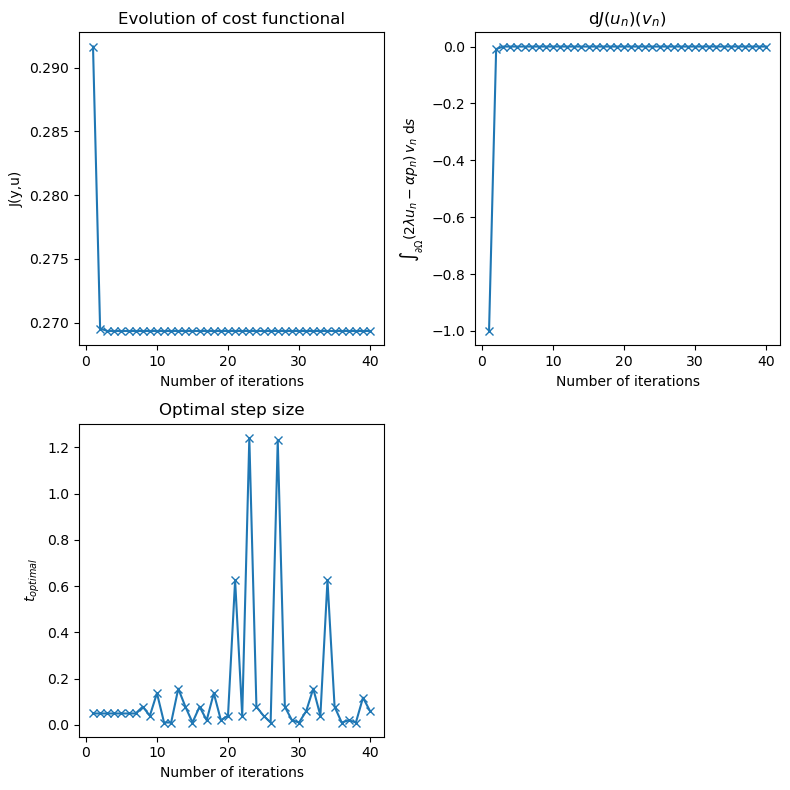

In [11]:
it_list = np.arange(1,niters+1)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(it_list, cost_list, 'x-')
plt.xlabel("Number of iterations")
plt.ylabel("J(y,u)")
plt.title("Evolution of cost functional")

plt.subplot(222)
plt.title(r"$\mathrm{d}J(u_n)(v_n)$")
plt.plot(it_list, descent_integrals, 'x-', label=r"$t_{opt}$")
plt.xlabel("Number of iterations")
plt.ylabel(r"$\int_{\partial \Omega} (2\lambda u_n - \alpha p_n)\, v_n \;\mathrm{d}s$")

plt.subplot(223)
plt.title("Optimal step size")
plt.plot(it_list, t_opt_list, 'x-')
plt.xlabel("Number of iterations")
plt.ylabel(r"$t_{optimal}$")

plt.tight_layout()
plt.show()

In [12]:
Draw(yn)
Draw(yref)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

In [13]:
n_not_in_bounds = np.sum(~((u.vec.FV().NumPy()[:] >= ua_np) & (u.vec.FV().NumPy()[:] <= ub_np)))
if n_not_in_bounds > 0:
    print(f"{n_not_in_bounds} u-values are not in U_admissible.")
else:
    print("All u-values are in U_admissible.")

All u-values are in U_admissible.


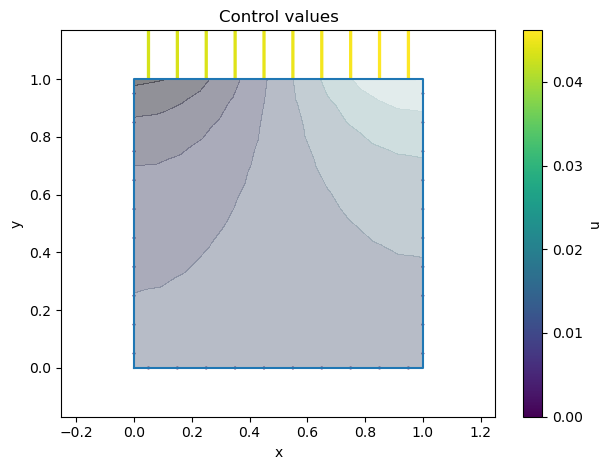

In [14]:
plot_control(yn, u)
# plt.savefig("plots\PG-bang_bang_control.svg")
plt.show()

Save the evolution of the cost functional.

In [15]:
import pandas as pd

if case == 1:
    mode = "all"
elif case == 2:
    mode = "top"
elif case == 3:
    mode = "bang_bang"

array = np.asarray([cost_list, descent_integrals, t_opt_list]).T
columns = ["J", "dJ", "stepsize"]
df = pd.DataFrame(array, columns=columns)
# df.to_csv(f"data\PG-{mode}.csv")
# df